In [63]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from meteostat import Point, Daily, units
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline


In [64]:
# Set time period
N = 75
end = datetime.now()
start = datetime(end.year - N, end.month, end.day)

# Create Point for NYC
nyc = Point(40.7789, -73.9692, 3.0)

# fetch data series
data = Daily(nyc, start, end)
data = data.convert(units.imperial)
data = data.fetch()


In [65]:
data["year"], data["month"], data["day"] = (
    data.index.year,
    data.index.month,
    data.index.day,
)


In [66]:
daily_max_avg = pd.DataFrame(
    data.tmax.groupby(by=[data.month, data.day]).mean())
daily_max_max = pd.DataFrame(
    data.tmax.groupby(by=[data.month, data.day]).max())


In [67]:
daily_max_avg["time"] = daily_max_avg.index.values
daily_max_avg

tmax      time
month day                     
1     1    41.460000    (1, 1)
      2    41.084000    (1, 2)
      3    40.401333    (1, 3)
      4    41.021333    (1, 4)
      5    39.620000    (1, 5)
...              ...       ...
12    27   39.636000  (12, 27)
      28   42.657333  (12, 28)
      29   42.064000  (12, 29)
      30   40.800000  (12, 30)
      31   41.341333  (12, 31)

[366 rows x 2 columns]

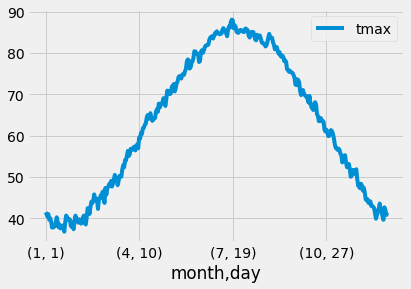

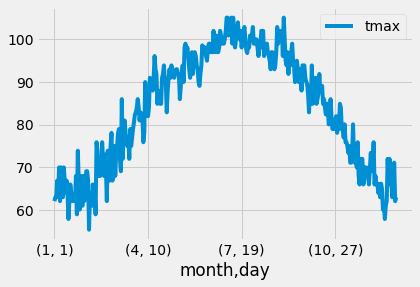

In [68]:
daily_max_avg.plot()
daily_max_max.plot()
plt.show()


In [70]:
# check if today hotter than average
today = end.strftime("%Y-%m-%d")
Month, Day, Year = end.month, end.day, end.year

todays_high = data.tmax.loc[today]
todays_avg_high = daily_max_avg.tmax.loc[(Month, Day)]
todays_max_high = daily_max_max.tmax.loc[(Month, Day)]

In [71]:
if todays_high > todays_avg_high:
    print(
        f"The high today in New York is {todays_high:.1f}°F, {todays_high - todays_avg_high:.1f}°F hotter than today's {N}-year average."
    )
else:
    print(
        f"The high today in New York is {todays_high:.1f}°F, {todays_high - todays_avg_high:.1f}°F cooler than today's {N}-year average."
    )
print(f"The {N}-year historical high for today is {todays_max_high:.1f}°F")


The high today in New York is 72.1°F, -4.2°F cooler than today's 75-year average.
The 75-year historical high for today is 90.0°F


In [72]:
# # scatter plot of today's temps
pd.options.mode.chained_assignment = None
daily_hist_series = data[(data["month"] == Month) & (data["day"] == Day)]
daily_hist_series["most_recent"] = np.where(
    daily_hist_series["year"] == daily_hist_series["year"].max(), 1, 0
)

In [73]:
daily_hist_series


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,year,month,day,most_recent
time,,,,,,,,,,,,,,
1948-06-03,NaN,59.0,75.0,0.012,0.0,NaN,NaN,NaN,NaN,NaN,1948,6,3,0
1949-06-03,NaN,52.0,73.9,0.000,0.0,NaN,NaN,NaN,NaN,NaN,1949,6,3,0
1950-06-03,NaN,60.1,81.0,0.000,0.0,NaN,NaN,NaN,NaN,NaN,1950,6,3,0
1951-06-03,NaN,64.0,77.0,0.020,0.0,NaN,NaN,NaN,NaN,NaN,1951,6,3,0
1952-06-03,NaN,59.0,82.0,0.000,0.0,NaN,NaN,NaN,NaN,NaN,1952,6,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-03,66.0,60.1,73.9,0.000,0.0,299.0,5.7,NaN,1012.3,NaN,2019,6,3,0
2020-06-03,69.3,60.8,78.8,0.799,0.0,265.0,7.3,NaN,1005.1,NaN,2020,6,3,0
2021-06-03,66.0,60.8,73.4,0.457,0.0,163.0,4.5,NaN,1018.1,NaN,2021,6,3,0


In [90]:
# add N year spline fit, with confidence bars
x, y =  daily_hist_series["year"].values.reshape(-1,1), daily_hist_series[["tmax"]].values.reshape(-1,1)
model = make_pipeline(SplineTransformer(n_knots=3, degree=3), Ridge(alpha=1e-3))
model.fit(x, y)

x_plot = np.linspace(Year - N, Year, 500).reshape(-1,1)
y_plot = model.predict(x_plot)

pct_bound = 0.10

upper_bound = y_plot * (1 + pct_bound)
lower_bound = y_plot * (1 - pct_bound)

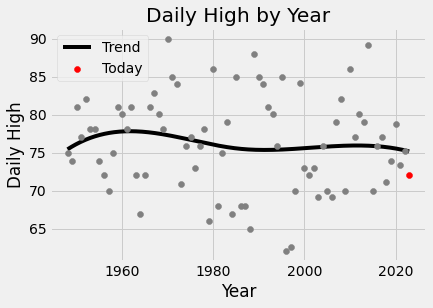

In [88]:
plt.style.use("fivethirtyeight")

plt.plot(x_plot, y_plot, color='Black', zorder=1, label='Trend')

plt.scatter(
    daily_hist_series["year"][daily_hist_series["most_recent"] == 0],
    daily_hist_series["tmax"][daily_hist_series["most_recent"] == 0],
    color="gray",
    zorder=2,
)
plt.scatter(
    daily_hist_series["year"][daily_hist_series["most_recent"] == 1],
    daily_hist_series["tmax"][daily_hist_series["most_recent"] == 1],
    color="red",
    label="Today",
    zorder=3,
)


plt.xlabel("Year")
plt.ylabel("Daily High")
plt.title("Daily High by Year")
plt.legend(loc="upper left")
plt.show()